## On Measuring Excess Capacity in Neural Networks

Florian Graf, Sebastian Zeng, Bastian Rieck, Marc Niethammer and Roland Kwitt

### Generate Simplex Classifier Prototypes

This notebook can be used to generate prototype weights for the SimplexClassifier.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import os
import copy
import math
import numpy as np
from itertools import islice
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.nn.utils import clip_grad_norm_

colors = ['tab:blue', 
          'tab:green',
          'tab:red']

DEVICE='cuda:0'

The two main parameters are the **number of classes** (`NUM_CLASSES`) and the **output dimensionality** of the layer right before the classifier (`OUT_DIM`).

In [12]:
NUM_CLASSES = 10
OUT_DIM = 128
PROTOTYPE_DIR = '/tmp'

Essentially, we seek to distribute `NUM_CLASSES` prototypes on the (`OUT_DIM`-1) unit sphere such that they form the vertices of a regular simplex. To solve this optimization problem we follow

Mettes et al.    
**Hyperspherical prototype networks**    
NeurIPS 2019
https://arxiv.org/pdf/1901.10514.pdf

in particular Eq. (5).

In [4]:
P = torch.randn(NUM_CLASSES, OUT_DIM)       
P = P/P.norm(dim=1, keepdim=True)
P.requires_grad = True

L = []
for i in range(1, 100000+1):
    opt = torch.optim.SGD([P], lr=0.5, momentum=0.9)
    opt.zero_grad()
    M = torch.mm(P,P.t()) - 2.*torch.eye(NUM_CLASSES)
    loss = torch.logsumexp(M, dim=1).mean()
    loss.backward()
    opt.step()
    
    L.append(loss.item())
    if i % 5000 == 0:
        print('Iteration: {:05d} | Loss: {:.9f}'.format(
            i, loss.item()))

    with torch.no_grad():
        P.data = P.data/P.data.norm(dim=1, keepdim=True)    
    
    P.requires_grad = True

Iteration: 05000 | Loss: 2.130779982
Iteration: 10000 | Loss: 2.130779982
Iteration: 15000 | Loss: 2.130779982
Iteration: 20000 | Loss: 2.130779982
Iteration: 25000 | Loss: 2.130779982
Iteration: 30000 | Loss: 2.130779982
Iteration: 35000 | Loss: 2.130779982
Iteration: 40000 | Loss: 2.130779982
Iteration: 45000 | Loss: 2.130779982
Iteration: 50000 | Loss: 2.130779982
Iteration: 55000 | Loss: 2.130779982
Iteration: 60000 | Loss: 2.130779982
Iteration: 65000 | Loss: 2.130779982
Iteration: 70000 | Loss: 2.130779982
Iteration: 75000 | Loss: 2.130779982
Iteration: 80000 | Loss: 2.130779982
Iteration: 85000 | Loss: 2.130779982
Iteration: 90000 | Loss: 2.130779982
Iteration: 95000 | Loss: 2.130779982
Iteration: 100000 | Loss: 2.130779982


### Some diagnostics

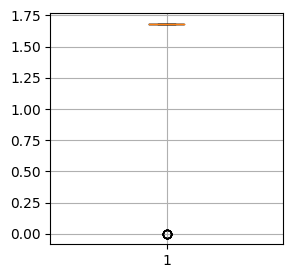

In [16]:
A = np.zeros((NUM_CLASSES, NUM_CLASSES))
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        A[i,j] = torch.acos(torch.dot(P[i,:],P[j,:])).item()
plt.figure(figsize=(3,3))
plt.boxplot(A[~np.isnan(A)].reshape(-1));
plt.grid()

In [24]:
assert torch.isnan(P).sum().item() == 0
assert torch.isinf(P).sum().item() == 0

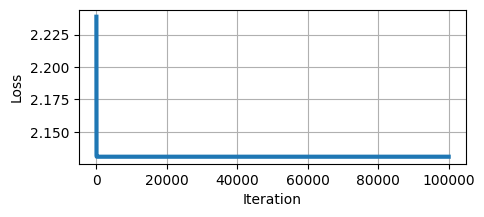

In [9]:
plt.figure(figsize=(5,2))
plt.plot(L,linewidth=3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid();

### Save prototypes

In [14]:
print(P.size())
torch.save(P, os.path.join(PROTOTYPE_DIR, 'prototypes_{}_{}.pt'.format(NUM_CLASSES, OUT_DIM)))
P = torch.load(os.path.join(PROTOTYPE_DIR, 'prototypes_{}_{}.pt'.format(NUM_CLASSES, OUT_DIM)))
print(P.size())

torch.Size([10, 128])
torch.Size([10, 128])


In [15]:
print('Theoretical Lip(f): {:.6f}'.format(np.sqrt(P.size(0)/(P.size(0)-1))))
print('Computed Lip(f)   : {:.6f}'.format(torch.linalg.svdvals(P).max().item()))

Theoretical Lip(f): 1.054093
Computed Lip(f)   : 1.054093
